In [1]:
import sys
sys.path.append('GAN')
from GAN.utils import *
from GAN.ops import *

import os
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time
import math
from glob import glob
from tensorflow.contrib import learn
import numpy as np
from tqdm import tqdm

In [2]:
class WGAN_GP(object):

  def __init__(self,
               sess,
               input_height=28,
               input_width=28,
               crop=True,
               batch_size=64,
               output_height=28,
               output_width=28,
               y_dim=None,
               z_dim=100,
               gf_dim=64,
               df_dim=64,
               gfc_dim=1024,
               dfc_dim=1024,
               c_dim=1,
               dataset_name='mnist',
               input_fname_pattern='*.jpg',
               checkpoint_dir='checkpoint',
               samples_dir=None,
               show_samples=False,
               learning_rate=2e-4,
               beta1=0.5,
               epoch=100):
    """
    Args:
      sess: TensorFlow session
      batch_size: The size of batch. Should be specified before training.
      y_dim: (optional) Dimension of dim for y. [None]
      z_dim: (optional) Dimension of dim for Z. [100]
      gf_dim: (optional) Dimension of gen filters in first conv layer. [64]
      df_dim: (optional) Dimension of discrim filters in first conv layer. [64]
      gfc_dim: (optional) Dimension of gen units for for fully connected layer. [1024]
      dfc_dim: (optional) Dimension of discrim units for fully connected layer. [1024]
      c_dim: (optional) Dimension of image color. For grayscale input, set to 1. [3]
        """
    self.sess = sess

    self.epoch = epoch
    self.batch_size = batch_size
    self.sample_num = 200
    self.learning_rate = learning_rate
    self.beta1 = beta1

    self.input_height = input_height
    self.input_width = input_width
    self.output_height = output_height
    self.output_width = output_width

    self.y_dim = y_dim
    self.z_dim = z_dim

    self.gf_dim = gf_dim
    self.df_dim = df_dim

    self.gfc_dim = gfc_dim
    self.dfc_dim = dfc_dim

    self.input_fname_pattern = input_fname_pattern
    self.dataset_name = dataset_name
    self.checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.samples_dir = samples_dir
    if not os.path.exists(samples_dir) and samples_dir is not None:
      os.makedirs(samples_dir)
    self.show_samples = show_samples

    self.trX, self.teX = self.load_mnist()
    self.ntrain = len(self.trX)
    self.c_dim = 1
    self.grayscale = (self.c_dim == 1)
    self.log = {'d_loss': [], 'g_loss': [], 'gen_samples': []}
    self.build_model()

  def build_model(self):

    # Training critic 5 iterations per generator iteration
    self.n_critic = 5

    image_dims = [self.input_height, self.input_width, self.c_dim]

    self.inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='real_images')
    self.sample_inputs = tf.placeholder(
        tf.float32, [None] + image_dims, name='sample_inputs')

    inputs = self.inputs
    sample_inputs = self.sample_inputs

    self.z = tf.placeholder(tf.float32, [None, self.z_dim], name='z')

    self.G = self.generator(self.z)
    
    self.D, self.D_logits_real = self.discriminator(inputs)
    self.D_, self.D_logits_fake = self.discriminator(self.G, reuse=True)

    self.d_loss_real = tf.reduce_mean(self.D_logits_real)
    self.d_loss_fake = tf.reduce_mean(self.D_logits_fake)
    self.g_loss = -tf.reduce_mean(self.D_logits_fake)
    self.d_loss = self.d_loss_fake - self.d_loss_real

    t_vars = tf.trainable_variables()

    self.d_vars = [var for var in t_vars if 'd_' in var.name]
    self.g_vars = [var for var in t_vars if 'g_' in var.name]
    self.saver = tf.train.Saver()

  def train(self):
    
    # modified
    
    alpha = tf.random_uniform(
        shape=[self.batch_size, 1], 
        minval=0.,
        maxval=1.
    )
    
    real_data = tf.reshape(self.inputs, [-1, 28 * 28])
    fake_data = tf.reshape(self.G, [-1, 28 * 28])
    
    differences = fake_data - real_data
    interpolates = real_data + (alpha * differences)
    
    reshape_interpolates = tf.reshape(interpolates, (-1, 28, 28, 1))
    
    print(reshape_interpolates.shape)
    gradients = tf.gradients(self.discriminator(reshape_interpolates, reuse=True), [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1.)**2)
    
    LAMBDA = 10 # Gradient penalty lambda hyperparameter
    self.d_loss += LAMBDA * gradient_penalty
    
    g_optim = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5,
        beta2=0.9
    ).minimize(self.g_loss, var_list=self.g_vars)
    
    d_optim = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5, 
        beta2=0.9
    ).minimize(self.d_loss, var_list=self.d_vars)
    
    '''
    g_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.g_loss, var_list=self.g_vars)
    d_optim = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        self.d_loss, var_list=self.d_vars)

    #get the weight clipping ops
    clip_ops = []
    for var in self.d_vars:
      clip_bounds = [-.01, .01]
      clip_ops.append(
          tf.assign(var, tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])))
    clip_disc_weights = tf.group(*clip_ops)
    '''

    init = tf.global_variables_initializer()
    self.sess.run(init)

    sample_z = np.random.uniform(-1, 1, size=(self.sample_num, self.z_dim))
    sample_idxs = np.random.randint(
        low=0, high=len(self.trX), size=self.sample_num)
    sample_inputs = self.trX[sample_idxs]

    counter = 1
    self.n_critic += 1
    start_time = time.time()
    for epoch in range(self.epoch):
      shuffle(self.trX)
      for batch_images in iter_data(self.trX, size=self.batch_size):
        batch_z = np.random.uniform(-1, 1, [self.batch_size,
                                            self.z_dim]).astype(np.float32)
        if counter % self.n_critic:
          # Update D network
          self.sess.run(
              d_optim, feed_dict={
                  self.inputs: batch_images,
                  self.z: batch_z,
              })
          #Apply weight clipping to D network
          # modified
          #self.sess.run(clip_disc_weights)
        else:
          # Update G network
          self.sess.run(
              g_optim, feed_dict={
                  self.z: batch_z,
              })
        counter += 1

      errD_fake = self.d_loss_fake.eval(
          session=self.sess, feed_dict={self.z: batch_z})
      errD_real = self.d_loss_real.eval(
          session=self.sess, feed_dict={self.inputs: batch_images})
      errG = self.g_loss.eval(session=self.sess, feed_dict={self.z: batch_z})
      self.log['d_loss'].append(errD_fake + errD_real)
      self.log['g_loss'].append(errG)
      print("Epoch: [%2d] time: %.2fs, d_loss: %.4f, g_loss: %.4f" \
        % (epoch,time.time() - start_time, errD_fake+errD_real, errG))

      if (epoch + 1) % 1 == 0:
        samples = self.sess.run(
            self.G, feed_dict={
                self.z: sample_z,
            })
        img = grayscale_grid_vis(
            samples,
            nhw=(10, 20),
            save_path=self.samples_dir + '/%d.jpg' % epoch)
        self.log['gen_samples'].append(img)
        if (epoch + 1) % 10 == 0:
          if self.show_samples:
            plt.imshow(img, cmap='gray')
            plt.axis('off')
            plt.show()

      if (epoch + 1) % 10 == 0:
        self.save(self.checkpoint_dir, counter)

  def discriminator(self, image, y=None, reuse=False):
    with tf.variable_scope("discriminator") as scope:
      if reuse:
        scope.reuse_variables()

      x = image
     
      # modified: remove all bn(batch normalization)  
      h0 = lrelu(conv2d(x, self.c_dim, name='d_h0_conv'))
      h1 = lrelu(conv2d(h0, self.df_dim, name='d_h1_conv'))
      h1 = flatten(h1)
      h2 = lrelu(linear(h1, self.dfc_dim, 'd_h2_lin'))
      h3 = linear(h2, 1, 'd_h3_lin')
    
      return tf.nn.sigmoid(h3), h3

  def generator(self, z, y=None):
    with tf.variable_scope("generator") as scope:
      s_h, s_w = self.output_height, self.output_width
      s_h2, s_h4 = int(s_h / 2), int(s_h / 4)
      s_w2, s_w4 = int(s_w / 2), int(s_w / 4)

      h0 = tf.nn.relu(linear(z, self.gfc_dim, 'g_h0_lin'))

      h1 = tf.nn.relu(linear(h0, self.gf_dim * 2 * s_h4 * s_w4, 'g_h1_lin'))
      h1 = tf.reshape(h1, [-1, s_h4, s_w4, self.gf_dim * 2])

      h2 = tf.nn.relu(deconv2d(h1, nf=self.gf_dim * 2, name='g_h2'))
      output = tf.nn.sigmoid(deconv2d(h2, nf=self.c_dim, name='g_h3'))
      return output

  def load_mnist(self):
    mnist = learn.datasets.load_dataset("mnist")
    train_data = mnist.train.images.reshape(-1, 28, 28, 1)  # Returns np.array
    test_data = mnist.test.images.reshape(-1, 28, 28, 1)  # Returns np.array
    return train_data, test_data

  @property
  def model_dir(self):
    return "%s_%s" % (self.dataset_name, self.batch_size)

  def save(self, checkpoint_dir, step):
    model_name = "DCGAN.model"
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    if not os.path.exists(checkpoint_dir):
      os.makedirs(checkpoint_dir)

    self.saver.save(
        self.sess, os.path.join(checkpoint_dir, model_name), global_step=step)

  def load(self, checkpoint_dir):
    import re
    print(" [*] Reading checkpoints...")
    checkpoint_dir = os.path.join(checkpoint_dir, self.model_dir)

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt and ckpt.model_checkpoint_path:
      ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
      self.saver.restore(self.sess, os.path.join(checkpoint_dir, ckpt_name))
      counter = int(next(re.finditer("(\d+)(?!.*\d)", ckpt_name)).group(0))
      print(" [*] Success to read {}".format(ckpt_name))
      return True, counter
    else:
      print(" [*] Failed to find a checkpoint")
      return False, 0

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


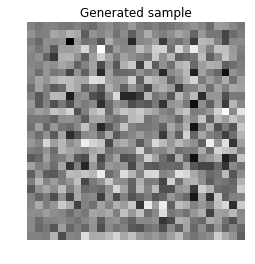

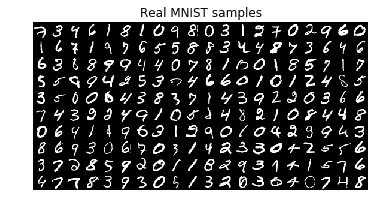

(16, 28, 28, 1)
Epoch: [ 0] time: 23.82s, d_loss: 7.2756, g_loss: -1.0155
Epoch: [ 1] time: 47.77s, d_loss: 5.3880, g_loss: -2.0883
Epoch: [ 2] time: 71.39s, d_loss: 1.3300, g_loss: -0.0024
Epoch: [ 3] time: 94.91s, d_loss: -5.7405, g_loss: 2.9193
Epoch: [ 4] time: 118.49s, d_loss: 1.7088, g_loss: -0.2269
Epoch: [ 5] time: 142.43s, d_loss: -5.1685, g_loss: 2.6746
Epoch: [ 6] time: 165.90s, d_loss: 5.9939, g_loss: -2.6114
Epoch: [ 7] time: 189.04s, d_loss: 7.1229, g_loss: -3.4874
Epoch: [ 8] time: 211.93s, d_loss: -8.3853, g_loss: 4.6805
Epoch: [ 9] time: 234.55s, d_loss: 4.1617, g_loss: -1.6158


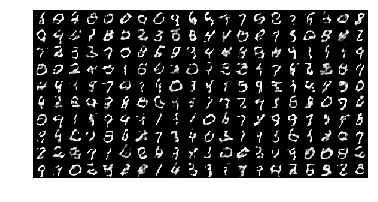

Epoch: [10] time: 259.05s, d_loss: 4.3103, g_loss: -1.8682
Epoch: [11] time: 282.23s, d_loss: 6.7333, g_loss: -2.9034
Epoch: [12] time: 305.82s, d_loss: 5.8273, g_loss: -2.4243
Epoch: [13] time: 329.21s, d_loss: -2.8894, g_loss: 1.4904
Epoch: [14] time: 352.16s, d_loss: 0.2940, g_loss: -0.0888
Epoch: [15] time: 375.54s, d_loss: 4.8686, g_loss: -2.1045
Epoch: [16] time: 399.25s, d_loss: 6.7838, g_loss: -3.2057
Epoch: [17] time: 422.09s, d_loss: -4.3855, g_loss: 2.2935
Epoch: [18] time: 445.99s, d_loss: -7.4710, g_loss: 3.9444
Epoch: [19] time: 469.57s, d_loss: 0.9341, g_loss: -0.2152


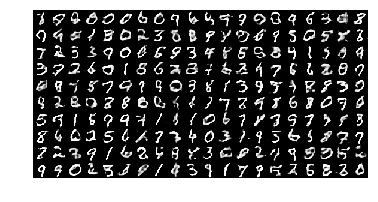

Epoch: [20] time: 494.30s, d_loss: -4.7713, g_loss: 2.5148
Epoch: [21] time: 517.94s, d_loss: 8.3753, g_loss: -4.2255
Epoch: [22] time: 541.74s, d_loss: -3.3397, g_loss: 1.9474
Epoch: [23] time: 565.23s, d_loss: -6.0283, g_loss: 3.0361
Epoch: [24] time: 588.96s, d_loss: 4.5532, g_loss: -2.1061
Epoch: [25] time: 612.60s, d_loss: -1.1251, g_loss: 0.6154
Epoch: [26] time: 635.92s, d_loss: -6.0246, g_loss: 2.8201
Epoch: [27] time: 659.22s, d_loss: -5.5276, g_loss: 2.7669
Epoch: [28] time: 682.36s, d_loss: -4.1080, g_loss: 2.0260
Epoch: [29] time: 705.54s, d_loss: 2.3727, g_loss: -1.0088


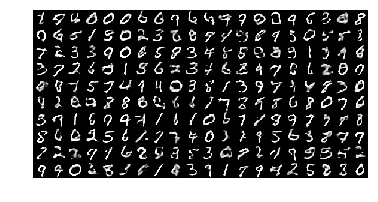

Epoch: [30] time: 730.17s, d_loss: 7.7657, g_loss: -3.7174
Epoch: [31] time: 753.82s, d_loss: -7.1997, g_loss: 3.1489
Epoch: [32] time: 777.36s, d_loss: 3.6958, g_loss: -1.6319
Epoch: [33] time: 801.11s, d_loss: -2.8260, g_loss: 1.6747
Epoch: [34] time: 824.39s, d_loss: 3.0496, g_loss: -1.6269
Epoch: [35] time: 848.12s, d_loss: 0.2403, g_loss: -0.0382
Epoch: [36] time: 872.21s, d_loss: 5.8804, g_loss: -2.4803
Epoch: [37] time: 895.97s, d_loss: 6.1494, g_loss: -3.1973
Epoch: [38] time: 919.24s, d_loss: -4.6242, g_loss: 2.6452
Epoch: [39] time: 942.43s, d_loss: -2.0630, g_loss: 0.9574


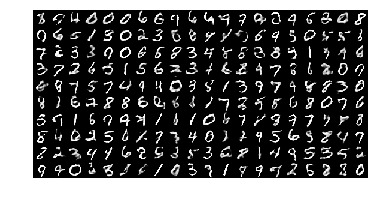

Epoch: [40] time: 965.61s, d_loss: -2.1378, g_loss: 1.2310
Epoch: [41] time: 986.60s, d_loss: -8.1960, g_loss: 3.8102
Epoch: [42] time: 1007.92s, d_loss: -0.7738, g_loss: 0.7966
Epoch: [43] time: 1028.84s, d_loss: -3.6644, g_loss: 1.9610
Epoch: [44] time: 1049.74s, d_loss: 6.8733, g_loss: -3.0601
Epoch: [45] time: 1070.49s, d_loss: 3.8870, g_loss: -2.1148
Epoch: [46] time: 1091.34s, d_loss: 9.3621, g_loss: -4.5376
Epoch: [47] time: 1111.96s, d_loss: 8.0046, g_loss: -3.8372
Epoch: [48] time: 1132.90s, d_loss: -7.3923, g_loss: 3.8818
Epoch: [49] time: 1153.98s, d_loss: 8.2961, g_loss: -4.1839


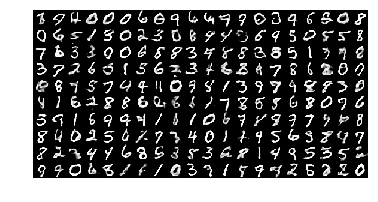

Epoch: [50] time: 1176.04s, d_loss: -6.7733, g_loss: 3.3675
Epoch: [51] time: 1197.01s, d_loss: -3.3688, g_loss: 1.8369
Epoch: [52] time: 1217.83s, d_loss: 1.0996, g_loss: -0.5988
Epoch: [53] time: 1238.82s, d_loss: -6.9004, g_loss: 3.1872
Epoch: [54] time: 1260.06s, d_loss: -2.5880, g_loss: 1.2547
Epoch: [55] time: 1281.04s, d_loss: 0.4496, g_loss: -0.1414
Epoch: [56] time: 1301.54s, d_loss: 5.9866, g_loss: -2.8771
Epoch: [57] time: 1322.06s, d_loss: -1.5353, g_loss: 0.9272
Epoch: [58] time: 1342.75s, d_loss: -6.0337, g_loss: 3.4986
Epoch: [59] time: 1363.61s, d_loss: 8.7317, g_loss: -4.2970


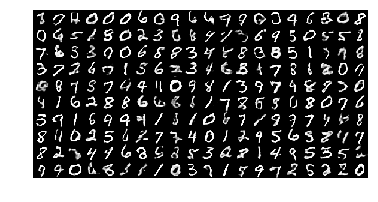

Epoch: [60] time: 1385.50s, d_loss: 9.0603, g_loss: -4.5093
Epoch: [61] time: 1406.16s, d_loss: 10.6204, g_loss: -5.0803
Epoch: [62] time: 1427.35s, d_loss: -1.5220, g_loss: 0.5544
Epoch: [63] time: 1448.17s, d_loss: -1.2374, g_loss: 0.9435
Epoch: [64] time: 1468.92s, d_loss: 8.9258, g_loss: -4.2697
Epoch: [65] time: 1489.83s, d_loss: -6.4462, g_loss: 3.2385
Epoch: [66] time: 1510.70s, d_loss: -3.7479, g_loss: 2.3194
Epoch: [67] time: 1531.46s, d_loss: -7.3896, g_loss: 3.6708
Epoch: [68] time: 1552.24s, d_loss: 4.7485, g_loss: -2.2161
Epoch: [69] time: 1573.31s, d_loss: 5.8132, g_loss: -2.9563


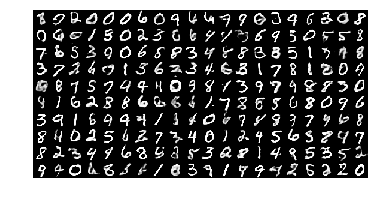

Epoch: [70] time: 1595.61s, d_loss: 7.4958, g_loss: -3.4538
Epoch: [71] time: 1616.92s, d_loss: 9.4950, g_loss: -5.5519
Epoch: [72] time: 1638.08s, d_loss: -5.8477, g_loss: 2.8256
Epoch: [73] time: 1659.14s, d_loss: 6.1357, g_loss: -3.0089
Epoch: [74] time: 1679.73s, d_loss: 1.6494, g_loss: -0.8776
Epoch: [75] time: 1700.53s, d_loss: -4.9952, g_loss: 2.4511
Epoch: [76] time: 1721.10s, d_loss: 1.8190, g_loss: -0.8525
Epoch: [77] time: 1741.95s, d_loss: -0.8022, g_loss: 0.3550
Epoch: [78] time: 1762.61s, d_loss: -7.6028, g_loss: 4.3519
Epoch: [79] time: 1783.35s, d_loss: 4.3704, g_loss: -1.9113


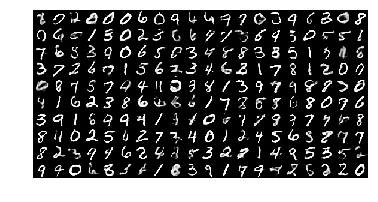

Epoch: [80] time: 1805.62s, d_loss: -8.2967, g_loss: 3.5723
Epoch: [81] time: 1826.78s, d_loss: 0.7354, g_loss: -0.2337
Epoch: [82] time: 1847.77s, d_loss: 6.6405, g_loss: -3.2353
Epoch: [83] time: 1868.52s, d_loss: -0.0315, g_loss: 0.0212
Epoch: [84] time: 1889.29s, d_loss: 1.3469, g_loss: -0.6576
Epoch: [85] time: 1910.33s, d_loss: 7.9409, g_loss: -4.0816
Epoch: [86] time: 1931.11s, d_loss: 4.0836, g_loss: -2.0979
Epoch: [87] time: 1952.02s, d_loss: 7.3244, g_loss: -3.6825
Epoch: [88] time: 1972.59s, d_loss: 9.3395, g_loss: -4.2449
Epoch: [89] time: 1993.25s, d_loss: -5.4578, g_loss: 2.8894


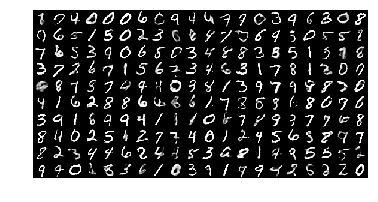

Epoch: [90] time: 2015.36s, d_loss: 2.4531, g_loss: -1.1696
Epoch: [91] time: 2036.21s, d_loss: 5.8035, g_loss: -3.0069
Epoch: [92] time: 2057.14s, d_loss: 7.9608, g_loss: -4.4614
Epoch: [93] time: 2078.05s, d_loss: 4.3826, g_loss: -1.9378
Epoch: [94] time: 2098.44s, d_loss: 4.4970, g_loss: -2.4188
Epoch: [95] time: 2118.67s, d_loss: 11.7491, g_loss: -5.3783
Epoch: [96] time: 2139.30s, d_loss: -7.2746, g_loss: 3.4913
Epoch: [97] time: 2159.85s, d_loss: 8.3774, g_loss: -3.9773
Epoch: [98] time: 2180.50s, d_loss: -8.2637, g_loss: 4.2482
Epoch: [99] time: 2201.32s, d_loss: -6.9455, g_loss: 3.8866


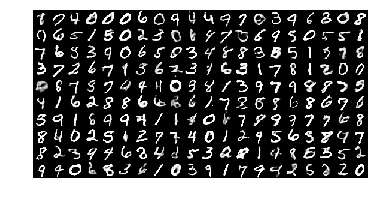

Epoch: [100] time: 2222.93s, d_loss: -8.4407, g_loss: 4.5740
Epoch: [101] time: 2243.39s, d_loss: -8.7148, g_loss: 4.2960
Epoch: [102] time: 2264.41s, d_loss: 1.3279, g_loss: -0.8495
Epoch: [103] time: 2285.13s, d_loss: 1.7586, g_loss: -0.8113
Epoch: [104] time: 2305.46s, d_loss: 9.7628, g_loss: -4.8557
Epoch: [105] time: 2326.03s, d_loss: 8.2687, g_loss: -4.6373
Epoch: [106] time: 2346.65s, d_loss: 10.3499, g_loss: -4.9946
Epoch: [107] time: 2367.30s, d_loss: -5.6005, g_loss: 2.9161
Epoch: [108] time: 2388.08s, d_loss: -8.0531, g_loss: 4.2921
Epoch: [109] time: 2409.00s, d_loss: 4.4436, g_loss: -2.2508


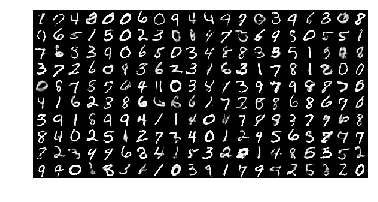

Epoch: [110] time: 2430.74s, d_loss: 5.5870, g_loss: -3.0443
Epoch: [111] time: 2451.18s, d_loss: 7.6159, g_loss: -4.2572
Epoch: [112] time: 2471.71s, d_loss: -6.3602, g_loss: 3.0146
Epoch: [113] time: 2492.14s, d_loss: -8.4998, g_loss: 4.0728
Epoch: [114] time: 2512.64s, d_loss: 6.3885, g_loss: -3.1627
Epoch: [115] time: 2533.45s, d_loss: 0.5871, g_loss: -0.0607
Epoch: [116] time: 2554.05s, d_loss: -5.5379, g_loss: 3.3097
Epoch: [117] time: 2574.75s, d_loss: 5.9207, g_loss: -2.9940
Epoch: [118] time: 2595.64s, d_loss: 0.5167, g_loss: -0.1874
Epoch: [119] time: 2616.55s, d_loss: 8.2322, g_loss: -4.4377


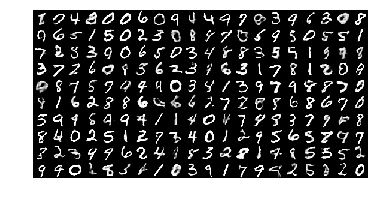

Epoch: [120] time: 2638.61s, d_loss: 0.0361, g_loss: -0.1844
Epoch: [121] time: 2658.98s, d_loss: -7.3426, g_loss: 3.7573
Epoch: [122] time: 2679.67s, d_loss: -0.5725, g_loss: 0.2988
Epoch: [123] time: 2700.07s, d_loss: 6.4834, g_loss: -3.0248
Epoch: [124] time: 2720.65s, d_loss: -4.0374, g_loss: 1.9607
Epoch: [125] time: 2741.33s, d_loss: 9.7475, g_loss: -4.0588
Epoch: [126] time: 2762.48s, d_loss: -4.9358, g_loss: 2.1458
Epoch: [127] time: 2783.52s, d_loss: 0.6776, g_loss: 0.0731
Epoch: [128] time: 2804.30s, d_loss: -7.9409, g_loss: 4.0836
Epoch: [129] time: 2825.33s, d_loss: 9.7273, g_loss: -4.8897


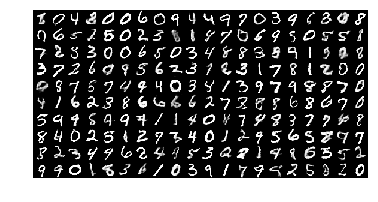

Epoch: [130] time: 2847.43s, d_loss: 6.4958, g_loss: -2.5996
Epoch: [131] time: 2868.20s, d_loss: -8.7265, g_loss: 3.8838
Epoch: [132] time: 2889.17s, d_loss: -7.7090, g_loss: 4.1364
Epoch: [133] time: 2910.18s, d_loss: -9.8250, g_loss: 4.5487
Epoch: [134] time: 2930.80s, d_loss: 6.5904, g_loss: -3.3086
Epoch: [135] time: 2951.61s, d_loss: 8.5473, g_loss: -4.2994
Epoch: [136] time: 2972.19s, d_loss: -8.8403, g_loss: 4.4916
Epoch: [137] time: 2992.78s, d_loss: 8.8420, g_loss: -4.2338
Epoch: [138] time: 3013.24s, d_loss: 6.8510, g_loss: -3.0928
Epoch: [139] time: 3034.27s, d_loss: 10.6673, g_loss: -4.8330


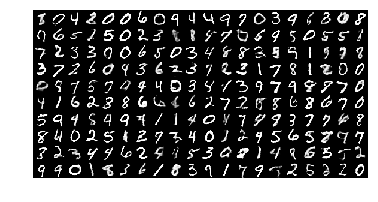

Epoch: [140] time: 3056.29s, d_loss: -6.7598, g_loss: 3.5626
Epoch: [141] time: 3077.19s, d_loss: 8.8877, g_loss: -4.1804
Epoch: [142] time: 3098.19s, d_loss: -8.9955, g_loss: 5.1489
Epoch: [143] time: 3119.13s, d_loss: 9.7156, g_loss: -4.5834
Epoch: [144] time: 3140.16s, d_loss: 10.8243, g_loss: -6.1026
Epoch: [145] time: 3161.06s, d_loss: 3.4661, g_loss: -1.4818
Epoch: [146] time: 3182.02s, d_loss: -5.1897, g_loss: 2.5023
Epoch: [147] time: 3203.02s, d_loss: 7.8209, g_loss: -4.4868
Epoch: [148] time: 3223.82s, d_loss: -9.6424, g_loss: 5.2606
Epoch: [149] time: 3244.73s, d_loss: 8.0564, g_loss: -3.7954


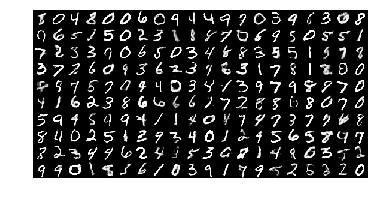

Epoch: [150] time: 3266.85s, d_loss: -6.7102, g_loss: 3.2015
Epoch: [151] time: 3287.80s, d_loss: -8.6745, g_loss: 4.4117
Epoch: [152] time: 3308.51s, d_loss: 1.4105, g_loss: -0.9370
Epoch: [153] time: 3329.21s, d_loss: 9.7970, g_loss: -4.4068
Epoch: [154] time: 3350.00s, d_loss: -4.9193, g_loss: 2.2996
Epoch: [155] time: 3370.79s, d_loss: -6.7779, g_loss: 3.9571
Epoch: [156] time: 3391.82s, d_loss: 9.4120, g_loss: -4.5686
Epoch: [157] time: 3412.64s, d_loss: -8.1633, g_loss: 4.8340
Epoch: [158] time: 3433.54s, d_loss: 7.7388, g_loss: -3.8800
Epoch: [159] time: 3454.26s, d_loss: 7.7006, g_loss: -3.3445


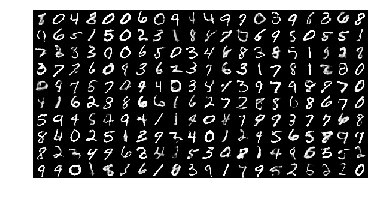

Epoch: [160] time: 3476.20s, d_loss: -5.8628, g_loss: 2.9695
Epoch: [161] time: 3497.15s, d_loss: -7.9954, g_loss: 3.9088
Epoch: [162] time: 3517.85s, d_loss: -6.1398, g_loss: 2.8841
Epoch: [163] time: 3538.84s, d_loss: -8.2159, g_loss: 4.4142
Epoch: [164] time: 3559.69s, d_loss: 5.5312, g_loss: -2.4643
Epoch: [165] time: 3580.67s, d_loss: 9.9741, g_loss: -4.8893
Epoch: [166] time: 3601.69s, d_loss: 10.2729, g_loss: -4.3754
Epoch: [167] time: 3622.40s, d_loss: 7.8757, g_loss: -3.8215
Epoch: [168] time: 3643.49s, d_loss: -9.1952, g_loss: 4.5209
Epoch: [169] time: 3664.45s, d_loss: -5.3009, g_loss: 3.1206


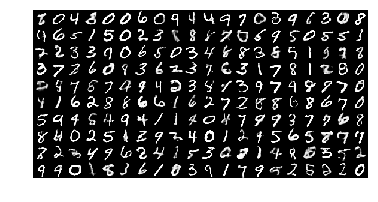

Epoch: [170] time: 3686.78s, d_loss: 6.3897, g_loss: -3.3060
Epoch: [171] time: 3707.66s, d_loss: -6.7520, g_loss: 3.2627
Epoch: [172] time: 3728.48s, d_loss: 3.6822, g_loss: -1.9454
Epoch: [173] time: 3749.22s, d_loss: -8.6242, g_loss: 4.4810
Epoch: [174] time: 3770.12s, d_loss: 3.4143, g_loss: -1.6567
Epoch: [175] time: 3790.95s, d_loss: 9.4098, g_loss: -4.6521
Epoch: [176] time: 3811.97s, d_loss: 7.5039, g_loss: -3.8002
Epoch: [177] time: 3832.74s, d_loss: -7.6933, g_loss: 3.6821
Epoch: [178] time: 3853.40s, d_loss: -1.5391, g_loss: 1.0073
Epoch: [179] time: 3874.14s, d_loss: -3.2167, g_loss: 1.6840


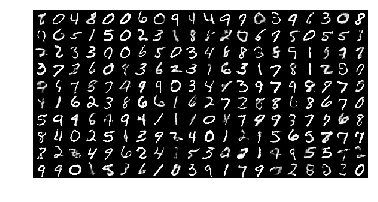

Epoch: [180] time: 3896.31s, d_loss: 5.5969, g_loss: -2.8255
Epoch: [181] time: 3916.86s, d_loss: 4.1558, g_loss: -1.6115
Epoch: [182] time: 3937.69s, d_loss: 7.7990, g_loss: -3.6459
Epoch: [183] time: 3958.63s, d_loss: 2.9505, g_loss: -1.5421
Epoch: [184] time: 3979.54s, d_loss: -7.0779, g_loss: 3.6866
Epoch: [185] time: 4000.34s, d_loss: 9.5133, g_loss: -4.3739
Epoch: [186] time: 4020.97s, d_loss: 4.7871, g_loss: -2.3082
Epoch: [187] time: 4041.45s, d_loss: 1.1815, g_loss: -0.4597
Epoch: [188] time: 4062.14s, d_loss: -2.3799, g_loss: 1.2045
Epoch: [189] time: 4082.66s, d_loss: 6.1734, g_loss: -2.8086


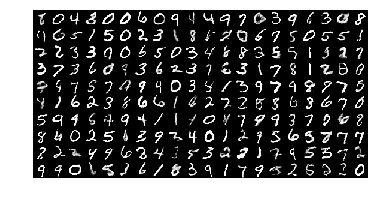

Epoch: [190] time: 4104.78s, d_loss: -3.2992, g_loss: 1.8027
Epoch: [191] time: 4125.70s, d_loss: -10.0005, g_loss: 5.0924
Epoch: [192] time: 4146.46s, d_loss: 8.3111, g_loss: -4.5187
Epoch: [193] time: 4166.89s, d_loss: 9.3648, g_loss: -4.3919
Epoch: [194] time: 4187.39s, d_loss: 8.2973, g_loss: -4.2746
Epoch: [195] time: 4208.08s, d_loss: -8.2427, g_loss: 4.1969
Epoch: [196] time: 4228.72s, d_loss: -0.8432, g_loss: 0.4107
Epoch: [197] time: 4249.51s, d_loss: 9.8552, g_loss: -4.8776
Epoch: [198] time: 4270.31s, d_loss: 1.1394, g_loss: -0.5046
Epoch: [199] time: 4291.15s, d_loss: -7.6291, g_loss: 4.1420


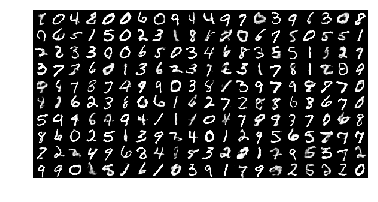

In [3]:
tf.reset_default_graph()

# Specifiy model checkpoint directory & samples directory
checkpoint_dir = 'checkpoint'
samples_dir = 'samples'

sess = tf.Session()
model = WGAN_GP(
    sess,
    input_width=28,
    input_height=28,
    output_width=28,
    output_height=28,
    batch_size=16,
    input_fname_pattern='*.jpg',
    checkpoint_dir=checkpoint_dir,
    samples_dir=samples_dir,
    show_samples=True,
    epoch=200)

# show_all_variables()
init = tf.global_variables_initializer()
sess.run(init)
sample_z = np.random.uniform(-1, 1, size=(200, 100))
samples = model.G.eval(session=model.sess, feed_dict={model.z: sample_z})
plt.imshow(samples[0].reshape(28, 28), cmap='gray')
plt.axis('off')
plt.title('Generated sample')
plt.show()

samples = model.trX[:200]
img = grayscale_grid_vis(samples, nhw=(10, 20))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Real MNIST samples')
plt.show()

model.train()

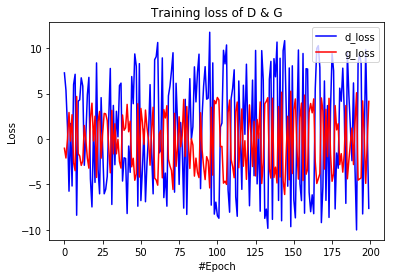

In [4]:
d_loss = model.log['d_loss']
g_loss = model.log['g_loss']
plt.plot(range(len(d_loss)), d_loss, color='blue', label='d_loss')
plt.plot(range(len(g_loss)), g_loss, color='red', label='g_loss')
plt.legend(loc="upper right")
plt.xlabel('#Epoch')
plt.ylabel('Loss')
plt.title('Training loss of D & G')
plt.show()

In [5]:
import imageio
imageio.plugins.ffmpeg.download()

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Error while fetching file: ('The read operation timed out',).
Try 2. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.016384/28549024 bytes (0.1%40960/28549024 bytes (0.1%90112/28549024 bytes (0.3%204800/28549024 bytes (0.7303104/28549024 bytes (1.1401408/28549024 bytes (1.4499712/28549024 bytes (1.8614400/28549024 bytes (2.2712704/28549024 bytes (2.5827392/28549024 bytes (2.9942080/28549024 bytes (3.31056768/28549024 bytes (3.7%1171456/28549024 bytes (4.1%1269760/28549024 bytes (4.4%1318912/28549024 bytes (4.6%1351680/28549024 bytes (4.7%1384448/28549024 bytes (4.8%1417216/28549024 bytes (5.0%1449984/28549024 bytes (5.1%1482752/28549024 bytes (5.2%1564672/28549024 bytes (5.5%1646592/28549024 bytes (5.8%1777664/28549024 bytes (6.2%1908736/28549024 bytes (6.7%2056192/28549024 bytes (7.2%2203648/28549024 bytes (7.7%2351104/2

In [6]:
#imageio.plugins.ffmpeg.download()
imgs = np.array(model.log['gen_samples'])
make_gif(imgs * 255., 'GAN/wgan.gif', true_image=True, duration=2)

from IPython.display import Image
Image(url='GAN/wgan.gif')


[MoviePy] Building file GAN/wgan.gif with imageio


100%|█████████▉| 200/201 [00:02<00:00, 71.58it/s]
